In [1]:
#import libraries
import json
import pandas as pd
import numpy as np
from sklearn.utils import resample
from collections import Counter
import matplotlib.pyplot as plt
from lsh import LSH
from minhash import create_minhash
from utils import proccess_df, get_duplicates, evaluate_metrics
import warnings
from tqdm import tqdm
from msm import get_msm_candidates
from collections import defaultdict
import scienceplots

# Step 1: Load the JSON file
with open('TVs-all-merged.json', 'r') as f:
    data = json.load(f)
    #make the json dictionary a dataframe
datalist = [] 
for model_id, products in data.items():
    for product in products:
        features = product.get("featuresMap", {})
        features["shop"] = product.get("shop", "unknown")
        features["url"] = product.get("url", "unknown")
        features["modelID"] = model_id
        features["title"] = product.get("title", "unknown")
        datalist.append(features)

# Convert to DataFrame
df = pd.DataFrame(datalist)
plt.style.use(['science', 'bright', 'no-latex'])

In [2]:
# I want to select some features to compare the products
# Count the frequency of keys in `featuresMap` across all products
key_counter = Counter()

for product in datalist:
    for key in product.keys():  # Iterate through all keys in each dictionary
        key_counter[key] += 1

# Sort the keys by frequency
sorted_keys = sorted(key_counter.items(), key=lambda x: x[1], reverse=True)

# Print the most common keys
print("Most commonly available keys in featuresMap:")
for key, count in sorted_keys[:15]:  # Display the top 10 keys
    print(f"{key}: {count} occurrences")

Most commonly available keys in featuresMap:
shop: 1624 occurrences
url: 1624 occurrences
modelID: 1624 occurrences
title: 1624 occurrences
Maximum Resolution: 1058 occurrences
Aspect Ratio: 922 occurrences
Brand: 867 occurrences
UPC: 773 occurrences
V-Chip: 757 occurrences
Screen Size (Measured Diagonally): 735 occurrences
USB Port: 728 occurrences
TV Type: 726 occurrences
Vertical Resolution: 716 occurrences
Screen Size Class: 712 occurrences
Component Video Inputs: 700 occurrences


In [4]:
n_bootstraps = 100
n_sample = int(0.6 * df.shape[0])
t_vals = np.arange(0, 1.05, 0.05)

pq_dict, pc_dict, f1_dict, f1_dict = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
pq_dict_msm, pc_dict_msm, f1_dict_msm, f1_dict_msm = defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list) 

for iter in tqdm(range(n_bootstraps), desc="Bootstrapping"):
    cur_df = resample(df, replace=True, n_samples=n_sample)
    cur_df_proc = proccess_df(cur_df)
    M = create_minhash(cur_df_proc)
    num_products = cur_df.shape[0]
    true_duplicates = get_duplicates(cur_df)
    num_funcs = M.shape[0]
    for t in t_vals:
        lsh = LSH(M, t)
        lsh_duplicates = lsh.get_candidate_pairs()
        lsh_duplicates = [(dup[0], dup[1]) for dup in lsh_duplicates]
        msm_duplicates = get_msm_candidates(cur_df_proc, lsh_duplicates)
        total_comparisons = num_products * (num_products - 1) // 2
        pq, pc, f1, comparisons = evaluate_metrics(lsh_duplicates, true_duplicates, total_comparisons)
        pq_dict.setdefault(comparisons, []).append(pq)
        pc_dict.setdefault(comparisons, []).append(pc)
        f1_dict.setdefault(comparisons, []).append(f1)
        pq, pc, f1, comparisons = evaluate_metrics(msm_duplicates, true_duplicates, total_comparisons)
        pq_dict_msm.setdefault(comparisons, []).append(pq)
        pc_dict_msm.setdefault(comparisons, []).append(pc)
        f1_dict_msm.setdefault(comparisons, []).append(f1)

    
pq_dict = {k: np.mean(v) for k, v in pq_dict.items()}
pc_dict = {k: np.mean(v) for k, v in pc_dict.items()}
f1_dict = {k: np.mean(v) for k, v in f1_dict.items()}
pq_dict_msm = {k: np.mean(v) for k, v in pq_dict_msm.items()}
pc_dict_msm = {k: np.mean(v) for k, v in pc_dict_msm.items()}
f1_dict_msm = {k: np.mean(v) for k, v in f1_dict_msm.items()}

Bootstrapping: 100%|██████████| 100/100 [12:12:45<00:00, 439.66s/it] 


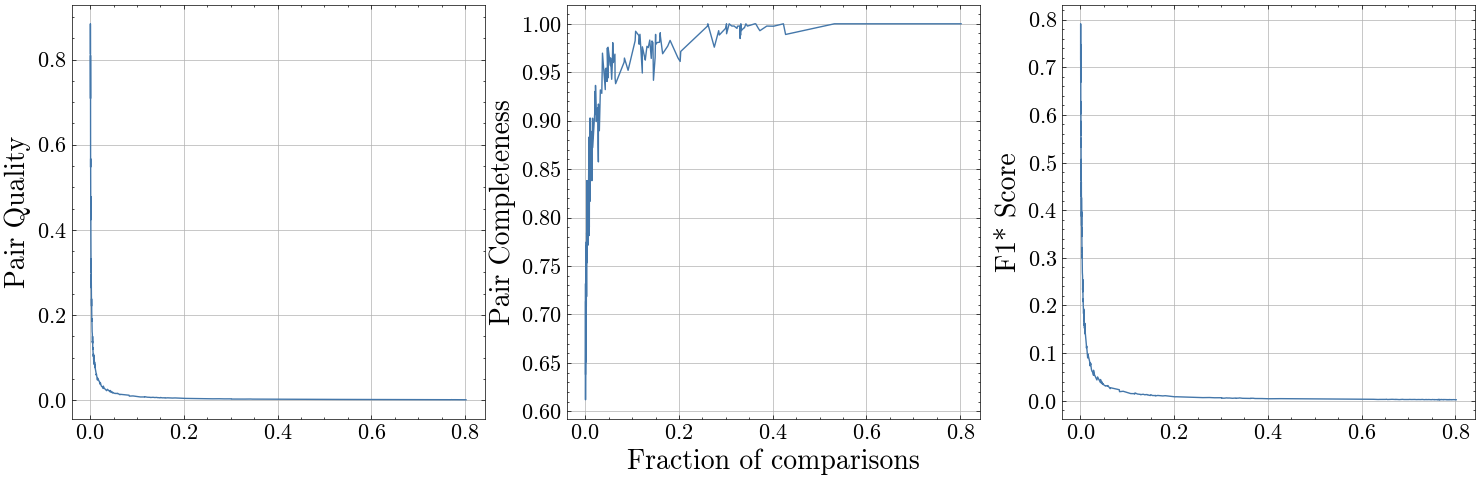

In [9]:
pq_dict = dict(sorted(pq_dict.items()))
pc_dict = dict(sorted(pc_dict.items()))
f1_dict = dict(sorted(f1_dict.items()))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First plot (PQ)
axes[0].plot(list(pq_dict.keys()), list(pq_dict.values()), label="PQ")
axes[0].set_ylabel("Pair Quality", fontsize=20)
axes[0].grid()
axes[0].tick_params(axis='both', which='major', labelsize=16)

# Second plot (PC)
axes[1].plot(list(pc_dict.keys()), list(pc_dict.values()), label="PC")
axes[1].set_ylabel("Pair Completeness", fontsize=20)
axes[1].set_xlabel("Fraction of comparisons", fontsize=20)
axes[1].grid()
axes[1].tick_params(axis='both', which='major', labelsize=16)

# Third plot (F1)
axes[2].plot(list(f1_dict.keys()), list(f1_dict.values()), label="F1*")
axes[2].set_ylabel("F1* Score", fontsize=20)
axes[2].grid()
axes[2].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('plot_lsh.pdf')


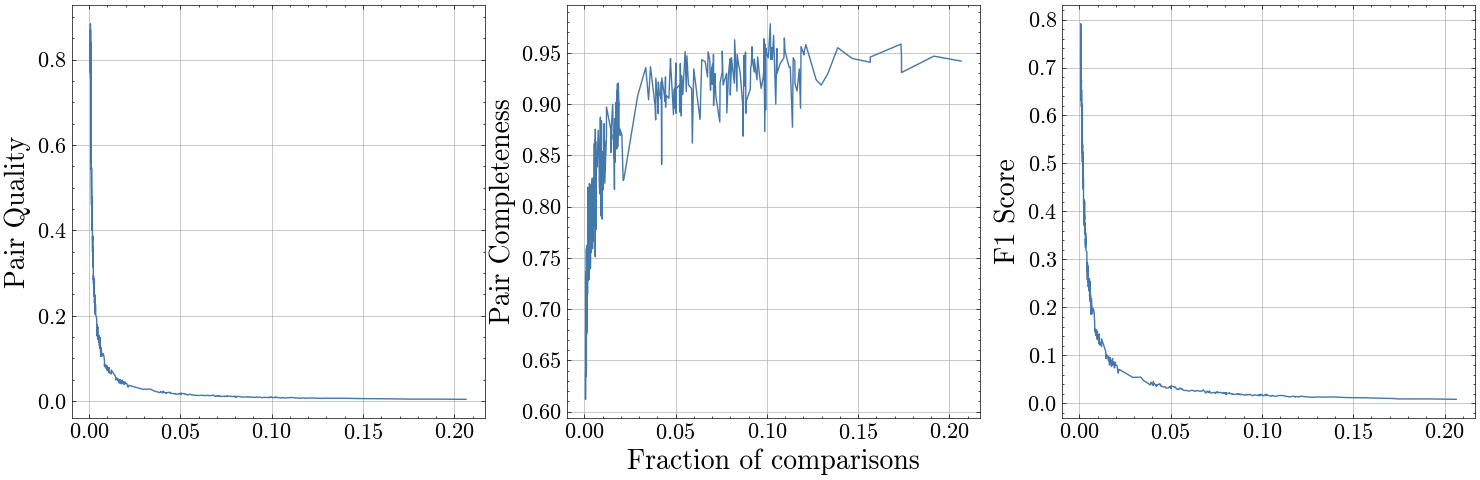

In [ ]:
pq_dict_msm = dict(sorted(pq_dict_msm.items()))
pc_dict_msm = dict(sorted(pc_dict_msm.items()))
f1_dict_msm = dict(sorted(f1_dict_msm.items()))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# First plot (PQ)
axes[0].plot(list(pq_dict_msm.keys()), list(pq_dict_msm.values()), label="PQ")
axes[0].set_ylabel("Pair Quality", fontsize=20)
axes[0].grid()
axes[0].tick_params(axis='both', which='major', labelsize=16)

# Second plot (PC)
axes[1].plot(list(pc_dict_msm.keys()), list(pc_dict_msm.values()), label="PC")
axes[1].set_ylabel("Pair Completeness", fontsize=20)
axes[1].set_xlabel("Fraction of comparisons", fontsize=20)
axes[1].grid()
axes[1].tick_params(axis='both', which='major', labelsize=16)

# Third plot (F1)
axes[2].plot(list(f1_dict_msm.keys()), list(f1_dict_msm.values()), label="F1")
axes[2].set_ylabel("F1 Score", fontsize=20)
axes[2].grid()
axes[2].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('plot_msm.pdf')
